In [ ]:
import pandas as pd
import numpy as np

# From Questions to Code

### Understanding data granularity

## Announcements
* On-line Tutorials: Exercise Caution!
    - https://afraenkel.github.io/practical-data-science/introduction
* SettingWithCopy Example.

## Data Granularity: What is an Individual?

<div class="image-txt-container">

- Tables consist of:
    - rows (individuals)
    - columns (measurements)


|Name|State|Color|Food|Date of Survey|
|---|---|---|---|---|
|Jane|NY|blue|Steak|2018|
|Aaron|CA|red|Mango|2017|
|Marina|IL|green|Apple|2015|
|...|...|...|...|...|

</div>    

What is an individual? A person? A survey response?


## Website Visits

<div class="image-txt-container">
    
<img src="imgs/netflix.png" width="50%">


* **Types of Individuals**
* Visits to netflix (browsing; video streamed)
* Customer accounts (paid subscriptions)

</div>


## Website Visits

<div class="image-txt-container">
    
<img src="imgs/netflix.png" width="50%">


- 140M streaming hrs/day (-\$)
- ~60M page visits/day (-\$)
- ~140M paid subscribers (+\$)
- 15M devices/day 
    * shared accounts?

</div>




# Design phase

If you can control how your dataset is created then you should determine the granularity of your data *before* collection. 

**Advantages**

- We can change a fine granularity to a coarse one if needed (how?)
- No need to collect additional data (saves time)


**Disadvantages**

- Expensive to collect
- Takes space



# Manipulating Granularity

* From the example above we saw that data can be represented in different levels. 

* In order to work with data from different tables we can change the granularity of the data. 

* The examples below will show you a techniques that allow you to manipulate granularity.



### Discussion Question

Given the table below, for each color, what proportion identify as 'M'?
* Return your answer as a Series, indexed by color.
* Try it first for one color.
* How many passes through the data does your solution require?


In [ ]:
people = pd.DataFrame(
    [["Joey", "blue", 42,"M"],
     ["Weiwei","blue", 50,"F"],
     ["Joey", "green", 8,"M"],
     ["Karina", "green",7, "F"],
     ["Fernando", "pink", -9,"M"],
     ["Nhi","blue",3,"F"],
     ["Sam","pink", -42,"X"]], 
    columns = ["Name", "FavColor", "Number", "Gender"])
people

### Approach 1: 'looping through unique values'

* How many passes through the data?
* What are the space constraints?

In [ ]:
colors = {}
for color in people['FavColor'].unique():
    filtered_for_color = people.loc[people['FavColor'] == color, : ]   # filter by color
    colors[color] = (filtered_for_color['Gender'] == 'M').mean()    # boolean array for "M" and take the mean

pd.Series(colors)

### Approach 2: 'single pass'

In [ ]:
people

In [ ]:
colors = {}                                                  # dict
for idx, row in people.iterrows():                            
    print(row)
    

In [ ]:
colors = {}                                                  # dict
for idx, row in people.iterrows():                            
    
    c, is_male = row['FavColor'], int(row['Gender'] == 'M')
    if c in colors:
        colors[c] += np.array([1, is_male])
    else:
        colors[c] = np.array([1, is_male])

colors

In [ ]:
df = pd.DataFrame(colors, index=['total', 'is_male'])
(df.loc['is_male'] / df.loc['total'])

### Issues with above solutions:

* Ad-hoc solution that depends on the specific problem.
* Loops in *python* are slow (though the *algorithmic reasoning* is still relevant).

What are the *common patterns* in processing 'groups of data'?

## Grouping and Aggregating Data

**split-apply-combine**

<img src="imgs/image_0.png"/>


**Aggregation** is the process of turning the values of a dataset (or a subset of it) into one single value.


### Pandas `groupby` objects

This makes clear what the `groupby` accomplishes:

* **split** breaks up and groups a `DataFrame` depending on the value of the specified key.
* **apply** computes a function (e.g. aggregate, transformation, or filtering) within the individual groups.
* **combine** merges the results of these operations into an output array.


### How `groupby` computes

* The `groupby` can (often) do this in a *single* pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way. 

* `groupby` abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

* Big data tools use the same design pattern to send the computations on each group across *many computers*.

## `groupby` and `aggregate/apply/transform`

* `groupby`: grouping collections of records over a set of fields for computing quantities over the remaining fields.
    - `groupby` is a dataframe method that returns a `groupby` object.


* `aggregate`: aggregating using one or more operations over the specified axis (also `apply/transform`)
    - `aggregate` is a `groupby` object method that returns a Series/DataFrame.



### `groupby` example

Given the table below, for each color, what proportion identify as 'M'?

In [ ]:
people

In [ ]:
people = people.assign(
        is_male=(people['Gender'] == 'M')
    )

In [ ]:
(
    people
    .groupby('FavColor')['is_male']
    .mean()
)

### `groupby` example

* `dataframe.groupby(key)` returns a `DataFrameGroupBy` object.
* `.groups` is a dictionary of grouping keys and the row labels in each group
* `.get_group(key)` method returns a dataframe corresponding to the given key


In [ ]:
# The `groupby` operator groups rows in the table that are the same in one or more columns.

grps = people.groupby("FavColor")
grps

In [ ]:
people

In [ ]:
grps.groups

In [ ]:
grps.size()

In [ ]:
grps.get_group('blue')

In [ ]:
for key, item in grps:
    print(key)
    print('=' * len(key))
    print(grps.get_group(key))
    print()
    print()

### `groupby` and column selection

* We will commonly combine `groupby` with column selection:
    - e.g., `df.groupby("Region")["Sales"]` 
* Then add an aggregate calculation on that column:

In [ ]:
people

In [ ]:
people.groupby('FavColor').mean()

In [ ]:
people.groupby("FavColor")["Number"].median()

In [ ]:
people.groupby("FavColor")["Number"].mean()

### Grouping over multiple columns

In [ ]:
# can you predict the output of the groupby?

two_fields = people.groupby(["FavColor", "Gender"])


In [ ]:
# To view the content:

for key, item in grps:
    print(key)
    print('=' * len(key))
    print(grps.get_group(key))
    print()
    print()

In [ ]:
res = people.groupby(["FavColor", "Gender"])[['Name','Number']].max()
res

In [ ]:
# ^^ multi-Index

In [ ]:
res.loc[('blue', 'F')]

### `groupby` methods

- `.min()`, `.max()`, `.mean()`, etc.
- What if what you want isn't provided by pandas?
- What if you want to apply different methods to different columns?

### `groupby` methods: `aggregate`
* Aggregates using one or more operations over the specified axis.
* Takes in a dictionary of:
    - keys: names of columns to a apply a function to,
    - values: the function to apply.
* There are more [sophisticated ways](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.aggregate.html#pandas.DataFrame.aggregate) to use it.

### Example

Get the proportion of `is_male` (mean) and the median number within each group of favorite colors.

In [ ]:
people.groupby('FavColor').aggregate({'Number': np.median, 'is_male': np.mean})

### Example

Get the average name length within each group.

In [ ]:
def avg_str_len(col):
    return col.str.len().mean()  # purpose?

In [ ]:
people.groupby('FavColor')['Name'].aggregate(avg_str_len)

In [ ]:
people

In [ ]:
# aggregate with list
people.groupby(['FavColor', 'Gender']).aggregate([np.min, np.max, 'size'])

`size`: the name of only certain functions as strings (originally). `Groupby` Implemented for a set number of functions. 
Why is this still allowed? backwards compatibility. 

### Animals at the zoo

In [ ]:
zoo = pd.read_csv("data/zoo.csv")
zoo.head(10)

In [ ]:
# 1. How much water is needed for all animals in a zoo?

zoo['water_need'].sum()

### Discussion Question

What happens if I execute zoo.sum()?

|Option|Answer|
|---|---|
|A:| Error|
|B:| sum will be calculated for the first column|
|C:| sum will be calculated for all columns|
|D:| sum wll be calcalculated for the last column|

In [ ]:
zoo

In [ ]:
zoo.sum()

In [ ]:
# Find the average consumption of water for each type of animal

zoo.groupby("animal")['water_need'].mean()

In [ ]:
# 4. Find the median consumption of water and the oldest animal within each animal category 
    

z = zoo.groupby('animal').aggregate({"age": np.max, "water_need": np.median})

z

### Grouping and Indexes

* the `groupby` operation creates an index based on the grouping columns. 
* If a grouping was one multiple columns, it results in a `MultiIndex`.
    - Advice: given a `MultiIndex`? Use `.reset_index`!

In [ ]:
# reminder

import numpy as np

def avg_str_len(series):
    return series.str.len().mean()  # purpose?

res = (
    people
        .groupby(["FavColor", "Gender"])
        .aggregate({"Name": avg_str_len, "Number": np.mean})
)

res

In [ ]:
# In some cases we might want to leave the grouping fields as columns:

(
    people
        .groupby(["FavColor", "Gender"], as_index=False)
        .aggregate({"Name": "first", "Number": np.mean})
)

In [ ]:
# Or using .reset_index instead

(
    people
        .groupby(["FavColor", "Gender"])
        .aggregate({"Name": "first", "Number": np.mean})
        .reset_index()
)

## `pivot` / `pivot_table` methods

* Pivot is used to examine aggregates with respect to two characteristics.
    - e.g. pivot sales data to look at average sales broken down by year and market.
* reshapes the rows *and the columns*  of a table


<img src="imgs/image_1.png" width="75%">

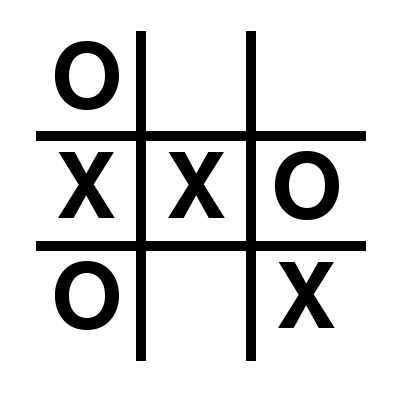

In [ ]:
pd.DataFrame([
    [1, 1, 'X'],
    [1, 2, 'O'],
    [0, 1, 'X'],
    [2, 1, 'O'],
    [2, 0, 'X'],
    [0, 2, 'O']
], columns=['i', 'j', 'move']).pivot(index='i', columns='j', values='move')

### `pivot`/ `pivot_table` methods reshape dataframes from 'long' to 'wide'
* `.pivot`/`.pivot_table` transforms:
    - a long table of rows 'indexed' by two characteristics,
    - into a wide table with one characteristic per axis.

* `.pivot` is a reshape that often follows a `groupby`.

In [ ]:
# Counts of Color/Gender
counts = people.groupby(["FavColor", "Gender"], as_index=False)['Number'].count()
counts

In [ ]:
# pivot method merely reshapes the data
counts.pivot(index='FavColor', columns='Gender', values='Number')

### The `pivot_table` method can combine `groupby` and `pivot`

* Doing a pivot after a groupby is so common, `pivot_table` can do it!
* `aggfunc='count'` specifies to aggregate by count before pivoting.
* The equivalent of:
```
people.groupby(["FavColor", "Sex"], as_index=False)['Number'].count().pivot('FavColor', 'Sex', 'Number')
```

In [ ]:
people.pivot_table(
    values  = "Number", # the entry to aggregate over
    index   = "FavColor",  # the row grouping attributes
    columns = "Gender",    # the column grouping attributes
    aggfunc = "count"   # the aggregation function
)

### `pivot_table` observations

1. The second "grouping" column (`Gender`) has been **"pivoted" from the rows to column location**. 
2. There is a missing value for `pink` and `F` since none of the women chose `pink` as their favorite color.
    - specify how missing values are filled in with `fill_value` keyword argument

In [ ]:
people.pivot_table(
    values  = "Number",
    index   = "FavColor",
    columns = "Gender",
    aggfunc = "count",
    #fill_value = 0.0
)

### `pivot_table` observations

* Rows/columns do *not* represent individuals/observations.
* The statistical summaries are related to joint/conditional distributions:
    - Joint: 'The distribution of (Color, Gender) pairs'
    - Conditional: 'The distribution of Colors, given Gender=...'

In [ ]:
counts = people.pivot_table(
    values  = "Number",
    index   = "FavColor",
    columns = "Gender",
    aggfunc = "count",
    fill_value = 0.0
)

counts

In [ ]:
joint = counts / counts.sum().sum()
joint

In [ ]:
joint.sum(axis=1)

In [ ]:
joint.sum(axis=0)

In [ ]:
# conditional distributions of color given Gender 
# (each column sums to 1)
counts / counts.sum(axis=0)

In [ ]:
# conditional distributions of Gender given Color
# (each column sums to 1)
counts.T / counts.sum(axis=1)

### `Pivot` conclusion

* Pivots reshape your data from long to wide.
* Other reshaping dataframe methods:
    - `melt`: un-pivots your data
    - `stack`: pivoting multi-level columns to multi-indices
    - `unstack`: pivoting multi-indices to columns

# Simpson's 'Paradox'

# Simpson's 'Paradox'
* Datasets look different at different granularities

<img src="imgs/image_2.png">

# Example 0.

- Two new students, A and B, take different number of classes in Fa, Wi, Sp quarter
- Within each quarter, student A has higher quarter GPA than B
- But B has higher overall GPA at the end of the year
- How is this possible?
- An A- in a 3 credit course is worth 3.7 $\times$ 3 = 11.1 "Grade Points"

In [ ]:
student_A = pd.DataFrame([
        [20, 46],
        [18, 54],
        [5, 20]
    ],
    columns=['Credit Hours', 'Grade Points Earned'], 
    index=['Fa', 'Wi', 'Sp'])
student_A

In [ ]:
student_B = pd.DataFrame([
        [5, 10],
        [5, 13.5],
        [22, 81.4]
    ],
    columns=['Credit Hours', 'Grade Points Earned'], 
    index=['Fa', 'Wi', 'Sp'])
student_B

In [ ]:
pd.DataFrame(
    {
        "A's Quarter GPA": student_A['Grade Points Earned'] / student_A['Credit Hours'],
        "B's Quarter GPA": student_B['Grade Points Earned'] / student_B['Credit Hours']
    }
)


In [ ]:
tot = student_A.sum()
tot['Grade Points Earned'] / tot['Credit Hours']

In [ ]:
tot = student_B.sum()
tot['Grade Points Earned'] / tot['Credit Hours']

### What happened?

- When Student A and B performed well, A didn't take many credit hours, but B did.
- When Student A and B performed poorly, A took a lot of credit hours, but B did not.

## Simpson's Paradox

* When grouped data tells the opposite story of the ungrouped data. 

* This *often* happens because there is a hidden factor (*a confounder*) within the data that influences results.

* What is the "correct" way to summarize your data? What if you had to act on these results?

# Example 1. How Berkeley was sued for gender discrimination

<img src="imgs/image_3.png">
**Do you agree?**

## Researchers looked more closely within specific departments

<img src="imgs/image_4.png">

**and what did they see?**

 - (from here: https://medium.com/@dexter.shawn/how-uc-berkeley-almost-got-sued-because-of-lying-data-aaa5d641f571)
 - https://en.wikipedia.org/wiki/Simpson%27s_paradox#UC_Berkeley_gender_bias

### What happened with admission?


<div class="image-txt-container">
    
<img src="imgs/simpsons_berkeley.png" width="50%">


* Most depts accepted women at a higher rate than men.
* Dept A: few women applicants
* Dept F: many women applicants
* Women apply to harder depts.

    
</div>




### What happened? (by the numbers)

* Overall acceptance rate: 35% (women) to 44% (men).

* Dept A has an acceptance rate 82% for women vs 62% for men! 
    - **2%** of all women applied to Dept A.
    - **10%** of all men applied to Dept A.
    
* Dept F has an acceptance rate 6% for women vs 7% for men! 
    - **8%** of all women applied to Dept A.
    - **4%** of all men applied to Dept A.

**Conclusion:** Women tend to apply to depts with a low-acceptance rate.

## Caution!

- This doesn't mean that admissions are free from gender discrimination.
- E.g., Moss-Racusin, et al, 2012, PNAS (cited 2600+ times):

> In a randomized double-blind study (n = 127), **science faculty** from research-intensive universities **rated the application materials of a student—who was randomly assigned either a male or female** name—for a laboratory manager position. Faculty **participants rated the male applicant as significantly more competent and hireable than the (identical) female applicant**. These participants also selected a higher starting salary and offered more career mentoring to the male applicant. The gender of the faculty participants did not affect responses, such that female and male faculty were equally likely to exhibit bias against the female student.

## But then...

- E.g., Williams and Ceci, 2015, PNAS:

> Here we report five hiring experiments in which faculty evaluated hypothetical female and male applicants, using systematically varied profiles disguising identical scholarship, for assistant professorships in biology, engineering, economics, and psychology. Contrary to prevailing assumptions, **men and women faculty members from all four fields preferred female applicants 2:1 over identically qualified males** with matching lifestyles (single, married, divorced), with the exception of male economists, who showed no gender preference.

## Do these conflict?

- Not necessarily. One explanation, from William and Ceci:

> Instead, past studies have used ratings of students’ hirability for a range of posts that do not include tenure-track jobs, such as managing laboratories or performing math assignments for a company. However, hiring tenure-track faculty differs from hiring lower-level staff: it entails selecting among highly accomplished candidates, all of whom have completed Ph.D.s and amassed publications and strong letters of support. **Hiring bias may occur when applicants’ records are ambiguous, as was true in studies of hiring bias for lower-level staff posts, but such bias may not occur when records are clearly strong**, as is the case with tenure-track hiring.

## Do these conflict?

- Witteman, et al, 2019, in *The Lancet*:

> Thus, evidence of scientists favouring women comes exclusively from hypothetical scenarios, whereas evidence of scientists favouring men comes from hypothetical scenarios and real behaviour. This **might reflect academics' growing awareness of the social desirability of achieving gender balance, while real academic behaviour might not yet put such ideals into action**.

## Lessons

- Be skeptical of aggregate statistics (Simpson's Paradox)
- Be skeptical of people misusing statistics to prove that discrimination doesn't exist
- Be skeptical of drawing conclusions from individual publications (p-hacking, publication bias, narrow focus)
- Be skeptical of everything!

# Example 2. Hospital Example

* Should I send my elderly relative to Hospital A or B?

<img src="imgs/hospitals.png">
    
[[from here]](https://www.youtube.com/watch?v=sxYrzzy3cq8&feature=youtu.be) 

### Additional observation:

Not all patients arrive with the same health:

<br/>

<div class="image-txt-container">
    
    
    
<img src="imgs/A_poor.png" width="42%">


<img src="imgs/B_poor.png" width="45%">

    
</div>


Calculate the survival rate for those in poor health.

In [ ]:
# for A:
print(30*100/100)
# for B:
print(210*100/400)

### Question

* What if your relative's health is good? 
* What hospital should you choose, A or B?

Remember, that hospital 
* A had 900/1000 survivors (30/100 poor health), (870/900 good health) 
* B has 800/1000 survivors (210/400 poor health), (590/600 good health). 

Talk to each other and vote:

|Option|Answer|
|---|---|
|A| Hospital A|
|B| Hospital B|
|C| Impossible to decide, not enough data|


### Simpson's paradox explanation: hospital example

* The data show opposite trends, depending on how it is grouped. 
* The hidden factor is the relative proportion of patients who arrived on good/poor health.
* *In this case*, how you act depends on which group you are in.

## Caution: Simpson's paradox is merely arithmetic

* Sometimes there are no *revelant* confounders.
* Simpson's paradox is present in ~2% of randomly chosen "grouping distributions".
* The best way to interpret the data depends on what you want from it!


### Restaurant reviews and phone types

* You are deciding between two restaurants with a friend.
* In a new feature, yelp aggregates attributes of reviewers for their reviews.
* Should you choose restaurant A or B? 

|Phone Type|Stars for A|Stars for B|
|---|---|---|
|Android|4.24|4.0|
|iPhone|2.99|2.79|
|___|___|___|
|All|3.32|3.37|



### Restaurant reviews and phone types
* It's doubtful that your phone-type will *cause* you to prefer one restaurant over another (?)
* If you aggregate again, the inequalities may flip *again* (e.g. phone-type ownership by zip-code)
* Simpson's paradox is merely a property of weighted averages!

* Maybe Android users give better reviews? But you care about relative rank!

### Verifying simpson's paradox
* Suppose we have a dataset of individual ratings
* Can you verify simpson's paradox?

In [ ]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()